# Global mean Sea Surface Temperatures

Create the following data files in netcdf format

**sstd** - SST monthly mean (time: 492,lat: 720,lon: 1440)

**sstd_WGlobalmean** - SST weighted global mean (time)

**sstd_Clim** - monthly climatology (month: 12lat: 720lon: 1440)

**sstd_anom** - anomaly from monthly Climatology (time: 492, lat: 720,lon: 1440)

**sstd_anom_WGlobalmean** - SST anomlay weighted global mean (time: 492)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter

import os

from dask.distributed import Client
from dask import delayed
import dask

plt.rcParams['figure.figsize'] = (10, 4)

#### Settings

In [7]:
#To compute de climatoloy
year1='1982'
year2='1992'

## Load data

In [10]:
# Load data
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = '/Users/pvb/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
if os.uname().nodename.lower().find('sagams') != -1:
    base_file = '/Users/pvb/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = '/data/shareddata/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'

In [11]:
files = [f'{base_file}.{year}.nc' for year in range(1982, 2025)]
sst = xr.open_mfdataset(files)
sstd = sst.sst

## Global mean
(weigthed and unweigthed)

In [13]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sstd.lat))
weights.name = "weights"

In [14]:
sstd_weighted = sstd.weighted(weights)

In [15]:
sstd_WGlobalmean = sstd_weighted.mean(("lon", "lat"),skipna=True)

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [16]:
#Create monthly climatology
sstd_Clim = sstd.sel(time=slice(year1,year2)).groupby('time.dayofyear').mean(dim='time');

In [17]:
#Create anomaly
sstd_anom = sstd.groupby('time.dayofyear') - sstd_Clim

/Users/pvb/miniconda3/envs/ocean/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


## Global mean anomaly

In [18]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sstd.lat))
weights.name = "weights"
sstd_anom_weighted = sstd_anom.weighted(weights)
sstd_anom_WGlobalmean = sstd_anom_weighted.mean(("lon", "lat"),skipna=True)
sstd_anom_WGlobalmean_rolling = sstd_anom_WGlobalmean.rolling(time=12,center=True).mean()

In [20]:
sstd_WGlobalmean_Y = sstd_WGlobalmean.resample(time='YE').mean(dim='time',skipna=True)
sstd_anom_WGlobalmean_Y = sstd_anom_WGlobalmean.resample(time='YE').mean(dim='time',skipna=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Mean global Sea Surface Temperature')

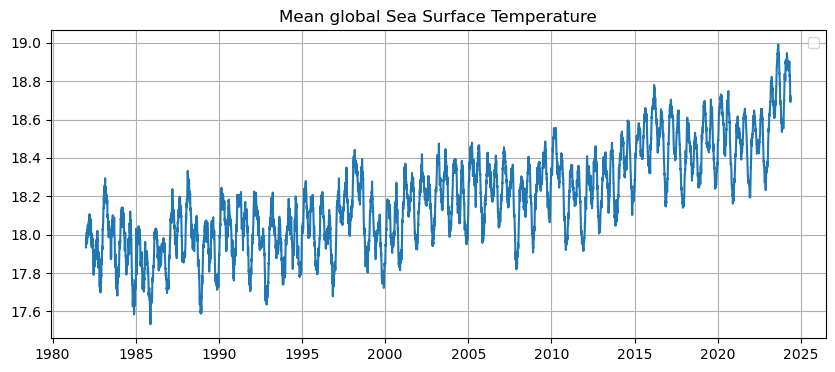

In [21]:
fig, ax = plt.subplots(1, 1 , figsize=(10,4))
ax.plot(sstd_WGlobalmean.time,sstd_WGlobalmean)
#ax.plot(sstd_WGlobalmean_Y.time,sstd_WGlobalmean_Y,'-b')
ax.grid()
ax.legend()
ax.set_title('Mean global Sea Surface Temperature')

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(10,4))
ax.plot(sstd_anom_WGlobalmean.time        ,sstd_anom_WGlobalmean,'b')
#ax.plot(sstd_anom_WGlobalmean_Y.time      ,sstd_anom_WGlobalmean_Y,'-b')
#ax.plot(sstd_anom_WGlobalmean_rolling.time,sstd_anom_WGlobalmean_rolling,'r')

ax.plot(sstd_anom_WGlobalmean.time.isel(sstd_anom_WGlobalmean.argmax(...)),
        sstd_anom_WGlobalmean.isel(sstd_anom_WGlobalmean.argmax(...)),'ro')
ax.plot(sstd_anom_WGlobalmean.time.isel(sstd_anom_WGlobalmean.argmin(...)),
        sstd_anom_WGlobalmean.isel(sstd_anom_WGlobalmean.argmin(...)),'bo')

ax.grid()
ax.legend()
ax.set_title('Mean global Sea Surface Temperature anomaly\n Anomaly computed from the 1982-1992 period');

In [ ]:
sstd_anom_WGlobalmean

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(sstd_Clim.mean(dim='lon').dayofyear,
                 sstd_Clim.mean(dim='lon').lat,
                 sstd_Clim.mean(dim='lon').transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + year1 + '-' + year2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

In [ ]:
#sstd.to_netcdf('noaa.oisst.v2.highres.sstd.nc')
#sstd_Clim.to_netcdf('noaa.oisst.v2.highres.sstdC.nc')
#sstd_anom.to_netcdf('noaa.oisst.v2.highres.sstdA.nc')

In [ ]:
sstd_WGlobalmean.to_netcdf('sstd_WGlobalmean.nc')
sstd_anom_WGlobalmean.to_netcdf('sstd_anom_WGlobalmean.nc')

### Canary Islands daily data

In [ ]:
sstd_NorteTenerife = sstd.sel(lon=360-16.1188,lat=28.5559,method='nearest').load()
sstd_anom_NorteTenerife = sstd_anom.sel(lon=360-16.1188,lat=28.5559,method='nearest').load()

In [ ]:
sstd_anom_NorteTenerife_rolling = sstd_anom_NorteTenerife.rolling(time=12,center=True).mean()
sstd_NorteTenerife_Y = sstd_NorteTenerife.resample(time='1Y').mean(dim='time',skipna=True)

In [ ]:
sstd_NorteTenerife.to_netcdf('sstd_NorteTenerife.nc')
sstd_anom_NorteTenerife.to_netcdf('sstd_anom_NorteTenerife.nc')

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(14,10))
ax.plot(sstd_NorteTenerife.time,sstd_NorteTenerife)
ax.grid()
ax.legend()
ax.set_title('Temperatura media Norte Tenerife')

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(14,8))
ax.plot(sstd_anom_NorteTenerife.time        ,sstd_anom_NorteTenerife,'b')
ax.plot(sstd_anom_NorteTenerife_rolling.time,sstd_anom_NorteTenerife_rolling,'r')
ax.plot(sstd_anom_NorteTenerife.time.isel(sstd_anom_NorteTenerife.argmax(...)),
        sstd_anom_NorteTenerife.isel(sstd_anom_NorteTenerife.argmax(...)),'ro')
ax.plot(sstd_anom_NorteTenerife.time.isel(sstd_anom_NorteTenerife.argmin(...)),
        sstd_anom_NorteTenerife.isel(sstd_anom_NorteTenerife.argmin(...)),'bo')
ax.legend()
ax.grid()
ax.set_title('Mean global Sea Surface Temperature anomaly');